In [ ]:
import os
import time
import uuid
import cv2

In [ ]:
path_to_images = os.path.join('data','images')
images_taken = 30

In [ ]:
#cap = cv2.VideoCapture(1)
#for imgnum in range(images_taken):
 #   print('Collecting image {}'.format(imgnum))
 #   ret, frame = cap.read()
 #   imgname = os.path.join(path_to_images,f'{str(uuid.uuid1())}.jpg')
 #   cv2.imwrite(imgname, frame)
#    cv2.imshow('frame', frame)
 #   time.sleep(0.5)

 #   if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break
#cap.release()
#cv2.destroyAllWindows()

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
images = tf.data.Dataset.list_files('/content/images_data/images/*.jpg')

In [ ]:
images.as_numpy_iterator().next()

b'/content/images_data/images/9675adf0-4e4b-11ee-bb76-00f48d9ba41c.jpg'

In [ ]:
def get_image(x):
  # returns a byte-encoded image
  byte_img = tf.io.read_file(x)

  # we decode the image and return it
  return tf.io.decode_jpeg(byte_img)

In [ ]:
images = images.map(get_image)

In [ ]:
#images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
# returns "batch_size" number of images
image_getter = images.batch(5).as_numpy_iterator()

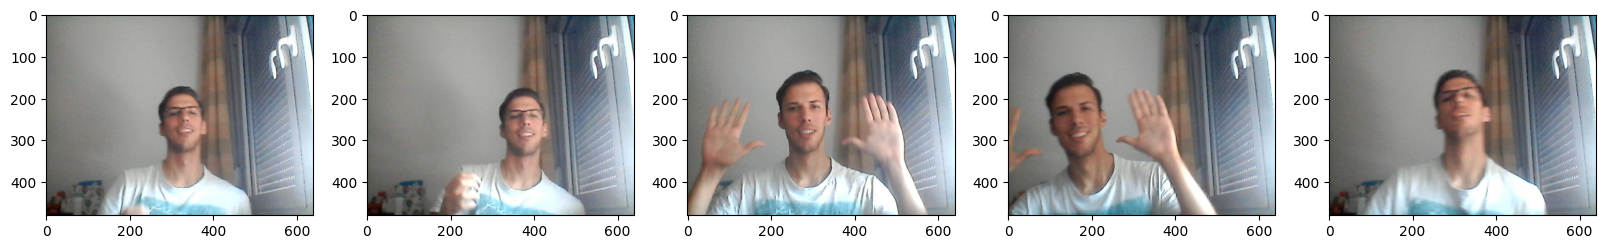

In [ ]:
show_images = image_getter.next()

fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(show_images):
  ax[idx].imshow(image)
plt.show()

In [ ]:
# Splitting the data to train, test, and validation partitions
# 60 to train, 15 to test, 15 to validation
# Done the splitting manually to ensure there is a proper variety of pictures in each partition

In [ ]:
for path in ['train', 'test', 'validation']:
  for file in os.listdir(os.path.join('/content/images_data', path, 'images')):
    file_name = file.split('.')[0] + '.json'
    label_filepath = os.path.join('/content/images_data', 'labeled_images', file_name)

    if os.path.exists(label_filepath):
      new_filepath = os.path.join('/content/images_data', path, 'labeled_images', file_name)
      os.replace(label_filepath, new_filepath)

In [ ]:
import albumentations as alb

In [ ]:
#image = cv2.imread(os.path.join('/content/images_data', 'images', '2023-05-08-111351_4.jpg'))

#image.shape

In [ ]:
image_augmentation = alb.Compose([alb.HorizontalFlip(p=0.5),
                                  alb.VerticalFlip(p=0.5),
                                  alb.RandomBrightnessContrast(p=0.2),
                                  alb.RGBShift(p=0.2),
                                  alb.RandomGamma(p=0.2),
                                  alb.RandomCrop(width=450, height=450)],
                                 bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [ ]:
rand_image = cv2.imread(os.path.join('/content/images_data', 'train', 'images', '9583c762-4e4b-11ee-ab30-00f48d9ba41c.jpg'))

In [ ]:
with open(os.path.join('/content/images_data', 'train', 'labeled_images', '9583c762-4e4b-11ee-ab30-00f48d9ba41c.json'), 'r') as f:
  image_label = json.load(f)

In [ ]:
image_label['shapes']

[{'label': 'face',
  'points': [[212.99516908212564, 148.21256038647343],
   [347.2946859903382, 356.42512077294685]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [ ]:
coordinates = [0,0,0,0]

coordinates[0] = image_label['shapes'][0]['points'][0][0]
coordinates[1] = image_label['shapes'][0]['points'][0][1]
coordinates[2] = image_label['shapes'][0]['points'][1][0]
coordinates[3] = image_label['shapes'][0]['points'][1][1]

coordinates

[212.99516908212564, 148.21256038647343, 347.2946859903382, 356.42512077294685]

In [ ]:
coordinates = list(np.divide(coordinates, [640,480,640,480]))

coordinates

[0.3328049516908213,
 0.30877616747181963,
 0.5426479468599035,
 0.7425523349436393]

In [ ]:
#tmp1 = coordinates[0]
#tmp2 = coordinates[1]
#coordinates[0] = coordinates[2]
#coordinates[2] = tmp1

##coordinates[1] = coordinates[3]
#coordinates[3] = tmp2

In [ ]:
coordinates

[0.3328049516908213,
 0.30877616747181963,
 0.5426479468599035,
 0.7425523349436393]

In [ ]:
augmented_image = image_augmentation(image=rand_image, bboxes=[coordinates], class_labels=['Face :)'])

In [ ]:
augmented_image['bboxes']

[(0.18665593129361255,
  0.3026945786366076,
  0.4850993022007516,
  0.7653891572732152)]

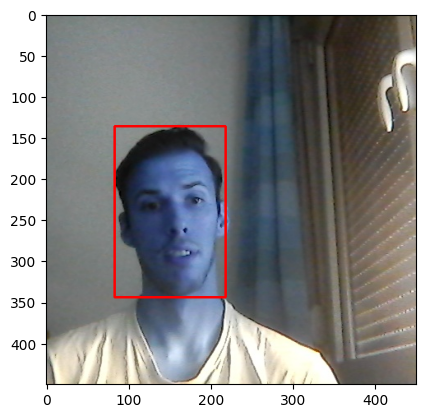

In [ ]:
cv2.rectangle(augmented_image['image'],
              tuple(np.multiply(augmented_image['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented_image['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented_image['image'])

In [ ]:
for partition in ['train', 'test', 'validation']:
  for image_path in os.listdir(os.path.join('/content/images_data', partition, 'images')):
    sample_image = cv2.imread(os.path.join('/content/images_data', partition, 'images', image_path))

    coordinates = [0, 0, 0.0001, 0.0001]
    label_path = os.path.join('/content/images_data', partition, 'labeled_images', f'{image_path.split(".")[0]}.json')
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        label = json.load(f)

        coordinates[0] = image_label['shapes'][0]['points'][0][0]
        coordinates[1] = image_label['shapes'][0]['points'][0][1]
        coordinates[2] = image_label['shapes'][0]['points'][1][0]
        coordinates[3] = image_label['shapes'][0]['points'][1][1]

        coordinates = list(np.divide(coordinates, [640,480,640,480]))
        x_min, y_min, x_max, y_max = coordinates[:4]
        if x_max <= x_min:
          coordinates[0], coordinates[2] = x_max, x_min
        if y_max <= y_min:
          coordinates[1], coordinates[3] = y_max, y_min

    try:
      for counter in range(60):
        augmented_image = image_augmentation(image=sample_image, bboxes=[coordinates], class_labels=['Face :)'])
        cv2.imwrite(os.path.join('/content/augmented_data', partition, 'images', f'{image_path.split(".")[0]}.{counter}.jpg'), augmented_image['image'])

        annotation = {}
        annotation['image'] = image_path

        if os.path.exists(label_path):
          if len(augmented_image['bboxes']) == 0:
            annotation['bbox'] = [0,0,0,0]
            annotation['class'] = 0
          else:
            annotation['bbox'] = augmented_image['bboxes'][0]
            annotation['class'] = 1
        else:
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0

        with open(os.path.join('/content/augmented_data', partition, 'labeled_images', f'{image_path.split(".")[0]}.{counter}.json'), 'w') as f:
          json.dump(annotation, f)

    except Exception as e:
      print(e)

In [ ]:
train_images = tf.data.Dataset.list_files('/content/augmented_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(get_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('/content/augmented_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(get_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('/content/augmented_data/validation/images/*.jpg', shuffle=False)
val_images = val_images.map(get_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
len(train_images)
#train.as_numpy_iterator().next()

3600

In [ ]:
def get_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [ ]:
train_labels = tf.data.Dataset.list_files('/content/augmented_data/train/labeled_images/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(get_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('/content/augmented_data/test/labeled_images/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(get_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('/content/augmented_data/validation/labeled_images/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(get_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
#len(train_labels)
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.291 , 0.2634, 0.5894, 0.726 ], dtype=float16))

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 900, 900, 900, 900)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1100)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1100)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.16  , 0.3137, 0.4585, 0.7764],
        [0.    , 0.    , 0.    , 0.    ],
        [0.3083, 0.2937, 0.6064, 0.7563],
        [0.2444, 0.2213, 0.543 , 0.684 ],
        [0.16  , 0.285 , 0.4585, 0.7476],
        [0.2578, 0.3184, 0.556 , 0.781 ],
        [0.4556, 0.2524, 0.754 , 0.715 ],
        [0.1355, 0.2279, 0.434 , 0.6904]], dtype=float16))

In [ ]:
batch_sample = train.as_numpy_iterator()

In [ ]:
res = batch_sample.next()

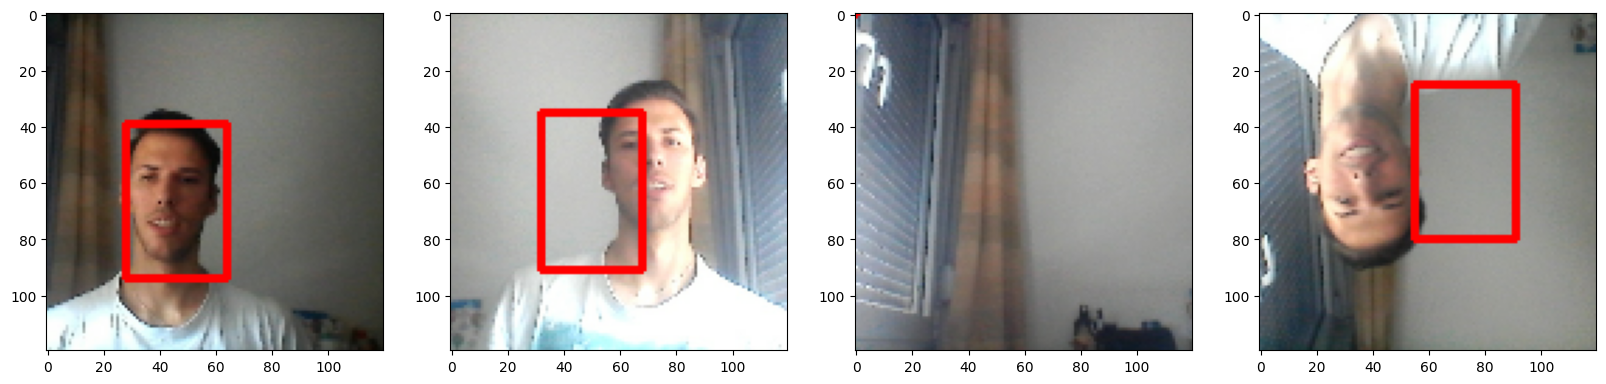

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [ ]:
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
#vgg.summary()

In [ ]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    return Model(inputs=input_layer, outputs=[class2, regress2])

In [ ]:
#train.as_numpy_iterator().next()[1]

In [ ]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [ ]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 2s 2s/step


(array([[0.47393116],
        [0.450256  ],
        [0.38424438],
        [0.5030572 ],
        [0.48591027],
        [0.36086825],
        [0.4298407 ],
        [0.4729927 ]], dtype=float32),
 array([[0.43882367, 0.42040718, 0.267235  , 0.36369184],
        [0.4265796 , 0.43272385, 0.18167517, 0.40869328],
        [0.31033206, 0.4434571 , 0.17209947, 0.50152665],
        [0.40340224, 0.43749344, 0.23041993, 0.46783742],
        [0.4217238 , 0.4431771 , 0.23546617, 0.43002695],
        [0.39104885, 0.4327582 , 0.21429493, 0.47815597],
        [0.47690564, 0.4131415 , 0.21640086, 0.39002353],
        [0.42760745, 0.43321258, 0.25357252, 0.41350526]], dtype=float32))

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
print(localization_loss(y[1], coords))
print(classloss(y[0], classes))
print(regressloss(y[1], coords))

tf.Tensor(3.7924986, shape=(), dtype=float32)
tf.Tensor(0.78870547, shape=(), dtype=float32)
tf.Tensor(3.7924986, shape=(), dtype=float32)


In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
450/450 [==============================] - 2144s 5s/step - total_loss: 0.4281 - class_loss: 0.1892 - regress_loss: 0.3335 - val_total_loss: 1.2684 - val_class_loss: 1.5022 - val_regress_loss: 0.5173
Epoch 2/10
450/450 [==============================] - 2150s 5s/step - total_loss: 0.0681 - class_loss: 0.0278 - regress_loss: 0.0542 - val_total_loss: 0.0442 - val_class_loss: 0.0342 - val_regress_loss: 0.0271
Epoch 3/10
450/450 [==============================] - 2201s 5s/step - total_loss: 0.0368 - class_loss: 0.0180 - regress_loss: 0.0278 - val_total_loss: 0.0036 - val_class_loss: 2.2844e-05 - val_regress_loss: 0.0036
Epoch 4/10
450/450 [==============================] - 2218s 5s/step - total_loss: 0.0432 - class_loss: 0.0250 - regress_loss: 0.0307 - val_total_loss: 0.2577 - val_class_loss: 0.2289 - val_regress_loss: 0.1433
Epoch 5/10
450/450 [==============================] - 2225s 5s/step - total_loss: 0.0197 - class_loss: 0.0081 - regress_loss: 0.0157 - val_total_loss: 0.002

In [ ]:
hist.history

{'total_loss': [0.08331889659166336,
  0.004671324044466019,
  0.012197139672935009,
  0.010693457908928394,
  0.008838703855872154,
  0.003846387378871441,
  0.0020158393308520317,
  0.005850497633218765,
  0.0018057876732200384,
  0.0004905601381324232],
 'class_loss': [0.0157390795648098,
  0.0002072961360681802,
  1.5847848771954887e-05,
  0.00029079316300339997,
  0.00013337279960978776,
  0.00019861548207700253,
  0.00019281290587969124,
  8.643664477858692e-05,
  2.4930652216426097e-05,
  1.7688003936200403e-05],
 'regress_loss': [0.07544935494661331,
  0.0045676757581532,
  0.01218921598047018,
  0.010548061691224575,
  0.008772017434239388,
  0.0037470797542482615,
  0.0019194327760487795,
  0.005807279143482447,
  0.0017933223862200975,
  0.00048171612434089184],
 'val_total_loss': [1.268425703048706,
  0.044205181300640106,
  0.0035689929500222206,
  0.25769102573394775,
  0.002496786881238222,
  0.003246668726205826,
  0.35391655564308167,
  0.00040459627052769065,
  2.0396

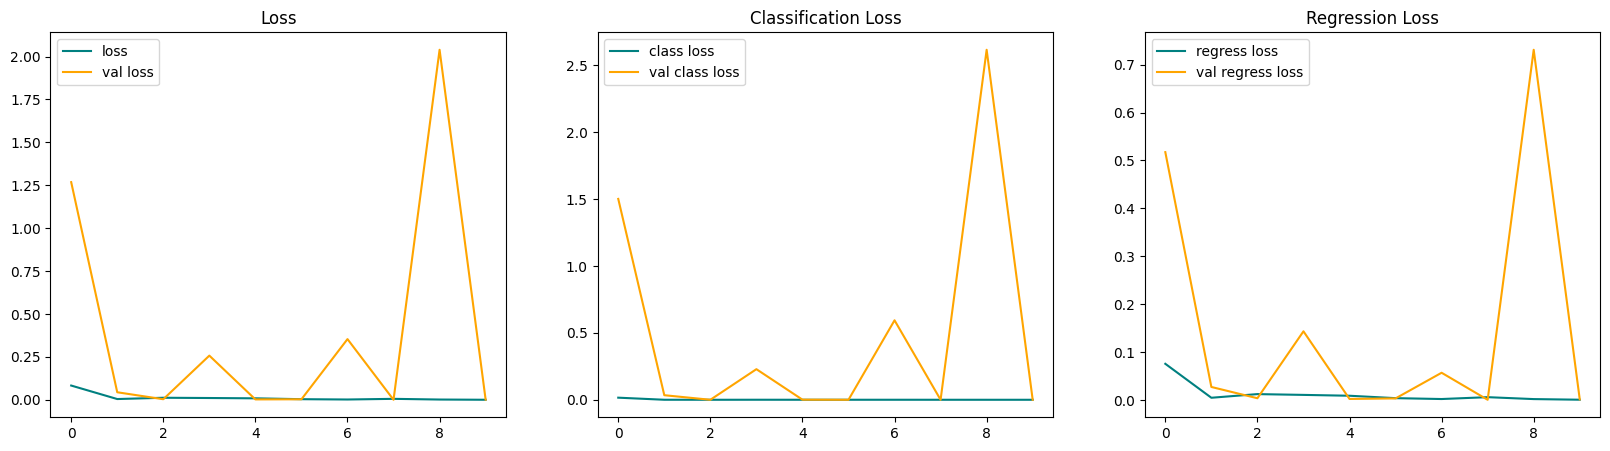

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


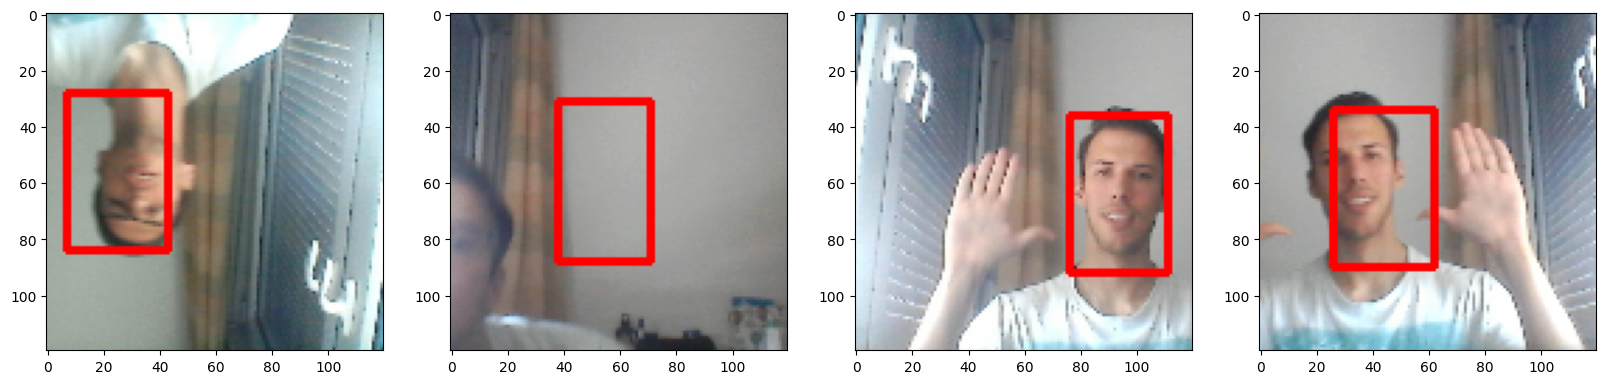

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker_v2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()